<a href="https://www.kaggle.com/code/daskoushik/resnet50-on-sign-language-classification?scriptVersionId=114348791" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Packages

In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Sequential, save_model, load_model
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ResNet50 Model:
* **identity_block**: contains three main components consisting of Convolutional->BathNorm->ReLU layers and a skip connection
* **convolutional_block**: contains three main components consisting of Convolutional->BathNorm->ReLU layers and a skip connection with a Convolutional->BathNorm Layers
* **ResNet50**: Uses identity and conolutional blocks to create a deep CNN with a total of 50 layers

In [2]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = 1, padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    # Third component of main path
    
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [3]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = 1, padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s,s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [4]:
def ResNet50(input_shape = (200, 200, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2) 
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512]) 
    
    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2) 
    X = identity_block(X, 3, [512, 512, 2048])  
    X = identity_block(X, 3, [512, 512, 2048])  

    X = AveragePooling2D((2,2))(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    model = Model(inputs = X_input, outputs = X)

    return model

# Load Dataset

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (200, 200)
directory = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             label_mode = 'categorical',
                                             seed=20)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             label_mode = 'categorical',
                                             seed=20)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [6]:
class_names = train_dataset.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


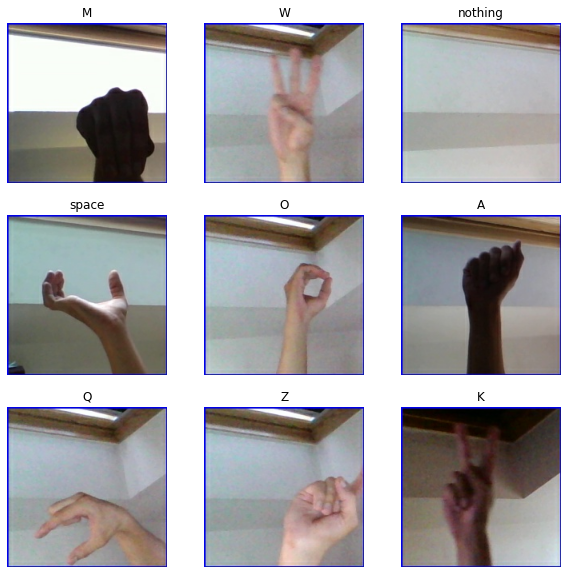

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("int"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Model Architecture

In [9]:
model = ResNet50(input_shape = (200, 200, 3), classes = 29)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 100, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

# Training Model
Commenting these as I've already saved my model and then imported as a dataset. You can run these if you want, the training acc - >99%, val acc - >99%

In [10]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# model.fit(train_dataset, validation_data=validation_dataset, epochs=5)

In [12]:
# acc = [0.] + model.history.history['accuracy']
# val_acc = [0.] + model.history.history['val_accuracy']

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

In [13]:
# model.save("modelASL.h5")

# Evaluating on test set

In [14]:
model = load_model('/kaggle/input/resnet50asl/modelASL.h5')

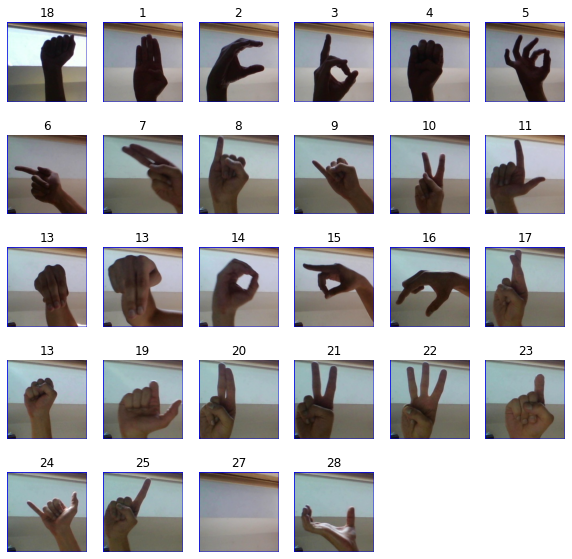

In [15]:
plt.figure(figsize=(10, 10))
for i in range(28):
    ax = plt.subplot(5, 6, i + 1)
    img_path = f"/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/%s_test.jpg"%chr(65+i)
    if i == 26:
        img_path = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/nothing_test.jpg"
    if i == 27:
        img_path = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/space_test.jpg"
    img = image.load_img(img_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    plt.imshow(img)
    plt.title(np.argmax(model.predict(img_batch)))
    plt.axis("off")


# Conclusion:
* Can not say about the model performance as the test set was small. Gotta change the train/val/test spilt and see the performance.
* It classified all of the above images correctly except for the letter 'A'